# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [ ] Add Lags for remaining districts
- [ ] Add / Replace `abs` values with `diff`
  - [x] Replace `lagged` variables with `diff`
  - [ ] Replace target variable with its `diff`
- [ ] Look-ahead values (e.g. 1 min 5 min 10 min 30 min) (tunable)
- [ ] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add `LightGBM` model
- [ ] Benchmark accuracy, train-time, inference-time (in progress)
- [x] Add data from more than 1 days


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from helper import cyclic_encode

In [2]:
df = pd.read_csv("data/processed/points_per_district.csv")

In [3]:
df = (
    df.pivot_table(
        index="timestamp", columns="district_id", values="crowd", aggfunc="sum"
    )
    .ffill()
    .bfill()
    .astype(np.uint16)
    .reset_index()
)
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

## Feature Extraction

1. Binning
2. Time-related Features
   1. Extraction
      1. Hour
      2. Minute
      3. Day of week
   2. Cyclic Encoding
3. Lagged Features
   1. 1-10 Minutes
   2. 15 Minutes
   3. 30 Minutes
   4. 60 Minutes
4. Rolling Mean Features
   1. Mean
   2. Std
   3. Var
   4. Kurtosis
   5. Skewness
5. Exponential Smoothing Features
   1. 5 Minutes
   2. 10 Minutes
   3. 15 Minutes
   4. 30 Minutes
   5. 60 Minutes


##### Binning


In [48]:
target_district = "Rotterdam Centrum"
target_column_name = f'{target_district.replace(" ", "_")}_c_lvl'

mean_crowd = df[target_district].mean()
std_crowd = df[target_district].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [49]:
c_lvl = pd.cut(
    df[target_district],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(np.uint16)

In [50]:
# c_lvl = c_lvl.sub(c_lvl.shift().fillna(0)).astype(int)
# c_lvl = c_lvl.add(abs(c_lvl.min()))
df[target_column_name] = c_lvl

Time-related Feature Extraction


In [8]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype(np.uint8),
}

Lagged and Rolling Feature Extraction


In [14]:
lagged_features = {}
rolling_features = {}
exp_smoothing_features = {}

for district in df.columns[1:]:
    lagged_features.update(
        {
            f"{district.replace(' ', '_')}_lag_{i}": df[district].shift(i).diff()
            for i in list(range(1, 11)) + [15, 30, 60]
        }
    )

    rolling_features.update(
        {
            f"{district.replace(' ', '_')}_rolling_{stat}_{window}": getattr(
                df[target_district].rolling(window=window), stat
            )()
            for window in [5, 10, 15, 30, 60]
            for stat in ["mean", "std", "var", "skew", "kurt"]
        }
    )

# Exponential smoothing
exp_smoothing_features.update(
    {
        f"{district.replace(' ', '_')}_ema_{window}": df[target_district]
        .ewm(com=0.25)
        .mean()
        for window in [5, 10, 15, 30, 60]
    }
)

In [37]:
lagged_df = (
    pd.concat(
        [
            df,
            pd.DataFrame(lagged_features),
            pd.DataFrame(rolling_features),
            pd.DataFrame(exp_smoothing_features),
            pd.DataFrame(time_related_features),
        ],
        axis=1,
    )
    .set_index("timestamp")
    .dropna()
)


lagged_df = cyclic_encode(lagged_df, "minute", 60)
lagged_df = cyclic_encode(lagged_df, "hour", 24)
lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

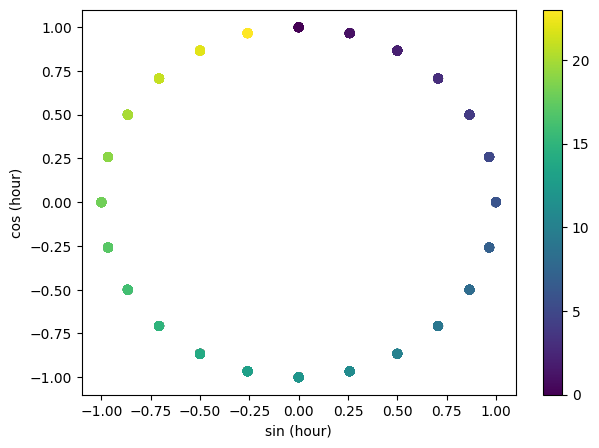

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(lagged_df["hour_sin"], lagged_df["hour_cos"], c=lagged_df["hour"])
ax.set(
    xlabel="sin (hour)",
    ylabel="cos (hour)",
)
_ = fig.colorbar(sp)

In [39]:
lagged_df.drop(columns=["minute", "hour", "day_of_week"], inplace=True)

#### Data Splitting


In [53]:
X = lagged_df.drop(columns=target_column_name)
y = lagged_df[target_column_name]

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [54]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

#### Pipeline Construction


In [55]:
num_features = X_train.select_dtypes(include=[np.float64]).columns.tolist()

In [56]:
from sklearn.preprocessing import OneHotEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_features),
        ("one-hot", OneHotEncoder(handle_unknown="ignore"), ["is_weekend"]),
    ],
    remainder="passthrough",
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", XGBClassifier(random_state=42)),
    ]
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Bedrijvenpark_Noord-West_lag_1',
                                                   'Bedrijvenpark_Noord-West_lag_2',
                                                   'Bedrijvenpark_Noord-West_lag_3',
                                                   'Bedrijvenpark_Noord-West_lag_4',
                                                   'Bedrijvenpark_Noord-West_lag_5',
                                                   'Bedrijvenpark_Noord-West_lag_6',
                                                   'Bedrijvenpark_Noord-West_lag_7',
                                                   'Be...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

##### Grid Search


In [57]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
    "estimator__reg_lambda": [0.3, 0.5, 0.7],
}

In [60]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="f1_micro",
    n_jobs=1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

cv_results = grid_search.cv_results_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best score: 1.000
Best parameters:
    - colsample_bytree: 0.5
    - learning_rate: 0.01
    - max_depth: 2
    - n_estimators: 50
    - reg_lambda: 0.3


In [61]:
best_model = grid_search.best_estimator_

In [62]:
for key, value in cv_results.items():
    if key.startswith(("mean_test", "test")):
        metric = key.split("_")[-1]
        print(f"{metric}: {value.mean():.3f} ± {value.std():.3f}")

accuracy: 1.000 ± 0.000
micro: 1.000 ± 0.000


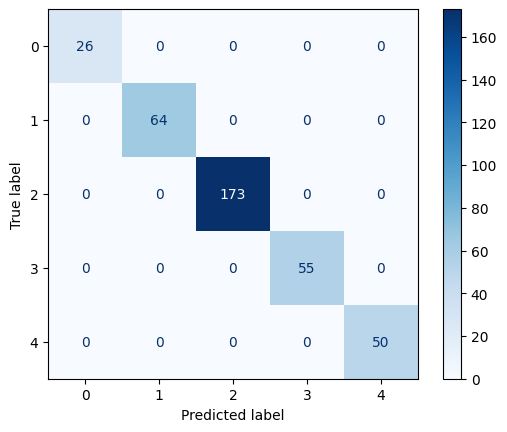

In [63]:
y_pred = best_model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

In [64]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["very_low", "low", "medium", "high", "very_high"],
    )
)

              precision    recall  f1-score   support

    very_low      1.000     1.000     1.000        26
         low      1.000     1.000     1.000        64
      medium      1.000     1.000     1.000       173
        high      1.000     1.000     1.000        55
   very_high      1.000     1.000     1.000        50

    accuracy                          1.000       368
   macro avg      1.000     1.000     1.000       368
weighted avg      1.000     1.000     1.000       368



# Model Evaluation

1. w/ `Feature Selection` (34 Features)
   1. Diff Lags + Rolling Stats
      1. Accuracy: 0.492 ± 0.010
      2. F1: 0.360 ± 0.027
   2. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.484 ± 0.009
      2. F1: 0.339 ± 0.028
2. w/out `Feature Selection` (52 Features)
   1. Diff Lags + Rolling Stats + EMA
      1. Accuracy: 0.854 ± 0.01
      2. F1-Micro: {0.854 ± 0.01}
